In [1]:
import sys
sys.path.append("../..")

#Defining libraries
import os
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import datacube
from copy import deepcopy

import rasterio
import pickle

from sklearn.preprocessing import OneHotEncoder
from modules import processing_module as processing
from modules.ai_module_extended import AIProcessor


2025-02-17 17:58:48.051567: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-17 17:58:48.053149: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-17 17:58:48.078767: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-17 17:58:48.079323: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-17 17:58:48.653234: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

## Define constants and files

In [2]:
'''
1-11-> Residential urban areas 
2-121,13->Industrial and abbandoned urban areas
3-122,123,124 Transportation infrastructure (streets, highways, airports, and ports)
4-14->Urban green areas
5-2->Agricultural areas
6-3->Forest
7-4/5->Hydro and humid bodies
'''
#Convert from copernicus code 2018 to an internal code
URBAN = 1
INDUSTRIAL = 2
TRANSPORTATION = 3
URBAN_VEGETATION = 4
RURAL = 5
FOREST = 6
WATER = 7
LC_NO_DATA = 9999
NO_DATA = -9999

    
# Function to check if the file is a tiff and must be read.
def check_wrong_files(f):
    if f == 'clip': return True #avoid entering the "clip" folder
    if 'ipynb' in f: return True #avoid entering the "ipynb_checkpoint" file
    if 'tar' in f: return True #avoid entering "tar" files
    if 'aux' in f: return True #avoid entering "aux" files
    return False

In [4]:
city = "MILANO"
city_epsg = 32632
data_folder = "data"
landcover_path = f"{data_folder}/landcover/DUSAF_2021_MCM_mapped.tif"
encode = True
#normalize = True
#train_model = True
#model = 'ANN'
#import samples
base_path = f'training_samples'
sufix = '_summer_mosaic_10000'
samples_path = f'{base_path}/{city}_samples{sufix}.csv'

## ODC functions - getting data from local datacube

In [5]:
def fetch_from_odc(odc_datasets, samples, x=None, y=None):
    odc_df = None
    for df_name in odc_datasets:
        print(f"Sampling {df_name}")
        #odc datasets to be merged
        odc_product = df_name

        datasets = dc.find_datasets(product=odc_product)
        cf_data = dc.load(datasets=datasets)
        if x is not None and y is not None:
            cf_sel = cf_data.squeeze().sel(
                y=y, 
                x=x, 
                method='nearest'
            )
        else:
            cf_sel = cf_data.squeeze()

        cf_var_name = list(cf_data.data_vars.keys())[0]
        cf_df = cf_sel.to_dataframe()
        del cf_sel
        
        cf_df.rename(columns={cf_var_name:odc_product},inplace=True)
        cf_df.drop(['time','spatial_ref'],axis=1,inplace=True)
        if 'x' in list(cf_df.columns): cf_df.drop(['x'],axis=1,inplace=True)
        if 'y' in list(cf_df.columns): cf_df.drop(['y'],axis=1,inplace=True)

        del cf_data
        
        if odc_df is None:
            odc_df = cf_df.copy()
            print(len(samples), len(odc_df))
            odc_df = pd.concat([samples, odc_df], axis=1)
        else:
            odc_df = pd.concat([odc_df, cf_df[odc_product].astype('float32')], axis=1)

    odc_df = odc_df.dropna()

    print('odc_df Ready!')
    return odc_df


In [6]:
#Example of datacube config file:
#datacube_config_path = "/home/user/datacube.conf"

datacube_config_path = "/home/user/datacube.conf"
dc = datacube.Datacube(app = "my_app", config = datacube_config_path)
products = dc.list_products()


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points


In [7]:
#The datasets from the ODC from which data is sampled
odc_datasets = [
    'building_height', 'densita_popolazione',
    'main_road_distance', 'river_distance', 
    'water_distance'
]

## Importing training data

The data is read from the sample path specified in the beginning

In [8]:
importer = processing.HarmoniaProcessor()

# get raster parameters
with rasterio.open(landcover_path, driver="GTiff") as base_raster:
    transform = base_raster.transform
    init_x = transform[2]
    init_y = transform[5]
    step_x = transform[0]
    step_y = transform[4]

samples = importer.import_df(samples_path, date_format=None)

samples['x'] = samples['x'].apply(
    lambda x: init_x + (x * step_x)
)
samples['y'] = samples['y'].apply(
    lambda y: init_y + (y * step_y)
)
samples = samples.loc[
    (samples['ndvi'] > -1) & 
    (samples['ndvi'] < 1) & 
    (samples['ndbi'] > -1) & 
    (samples['ndbi'] < 1) & 
    (samples['albedo'] > 0) & 
    (samples['albedo'] < 1)
]

samples


,x,y,landcover,uhi,uhii,ndvi,ndbi,albedo,lst,raster
0,498936.1148,5039675.992,2,0,-1.437195,0.621937,-0.402585,0.141624,306.28190,2016
1,508646.1148,5024915.992,1,0,-2.409638,0.746379,-0.370001,0.139510,305.30945,2016
2,501531.1148,5029345.992,2,0,-4.547577,0.860025,-0.418898,0.180081,303.17150,2016
3,486811.1148,5038835.992,3,0,-0.268219,0.808178,-0.389560,0.147665,307.45087,2016
4,526396.1148,5027655.992,2,0,-0.985992,0.865068,-0.491505,0.136227,306.73310,2016
...,...,...,...,...,...,...,...,...,...,...
69995,506376.1148,5020810.992,5,1,2.977936,0.800209,-0.292193,0.172404,310.17330,2018
69996,496936.1148,5050035.992,5,1,5.743103,0.602893,-0.128996,0.166451,312.93848,2018
69997,527951.1148,5042505.992,5,1,0.475952,0.654087,-0.246778,0.137191,307.67133,2018
69998,497041.1148,5037895.992,4,1,7.312012,0.675188,-0.156947,0.105158,314.50740,2018


In [9]:
# Compute mean and standard deviation of the 'uhii' column
mean_uhii = samples['uhii'].mean()
std_uhii = samples['uhii'].std()

# Define upper and lower bounds for outlier removal
lower_bound = mean_uhii - 3 * std_uhii
upper_bound = mean_uhii + 3.5 * std_uhii

# Filter the dataset to remove outliers
samples = samples[(samples['uhii'] >= lower_bound) & (samples['uhii'] <= upper_bound)]


In [10]:
samples.describe()

,x,y,landcover,uhi,uhii,ndvi,ndbi,albedo,lst,raster
count,69932.000000,6.993200e+04,69932.000000,69932.000000,69932.000000,69932.000000,69932.000000,69932.000000,69932.000000,69932.000000
mean,508935.628399,5.033600e+06,3.374535,0.500357,1.534469,0.584766,-0.200066,0.154054,310.989633,2018.713093
std,16306.872784,9.709715e+03,1.780943,0.500003,4.915279,0.212670,0.174283,0.037593,5.678960,2.373792
min,477061.114800,5.001026e+06,1.000000,0.000000,-13.147888,-0.722805,-0.656699,0.003154,294.228240,2015.000000
25%,495846.114800,5.026046e+06,2.000000,0.000000,-1.898529,0.422491,-0.344655,0.136054,306.533100,2016.000000
50%,507788.614800,5.034311e+06,3.000000,1.000000,0.008469,0.619177,-0.202445,0.152345,310.103255,2019.000000
75%,521841.114800,5.041511e+06,5.000000,1.000000,5.512512,0.770695,-0.057841,0.168733,314.951720,2021.000000
max,542996.114800,5.054421e+06,6.000000,1.000000,18.757843,0.992149,0.387469,0.986203,332.173980,2022.000000


## Training samples statistics

Correlation, PCA and line plots contrasting all the training features

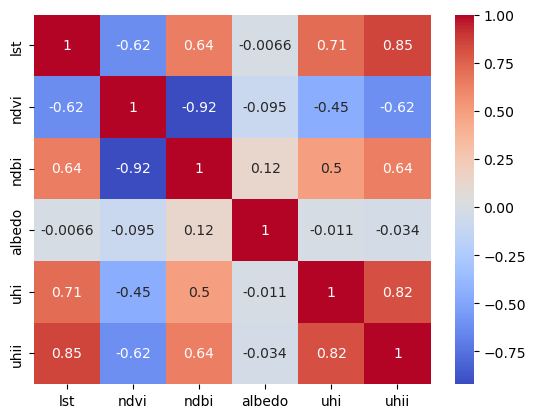

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = samples[["lst", "ndvi", "ndbi", "albedo", "uhi","uhii"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()


In [10]:
corr

,lst,ndvi,ndbi,albedo,uhi,uhii
lst,1.000000,-0.322266,0.573200,0.006930,0.680518,0.835605
ndvi,-0.322266,1.000000,-0.535306,0.029849,-0.259248,-0.319080
ndbi,0.573200,-0.535306,1.000000,-0.065398,0.490647,0.574618
albedo,0.006930,0.029849,-0.065398,1.000000,0.004731,0.004341
uhi,0.680518,-0.259248,0.490647,0.004731,1.000000,0.804506
uhii,0.835605,-0.319080,0.574618,0.004341,0.804506,1.000000


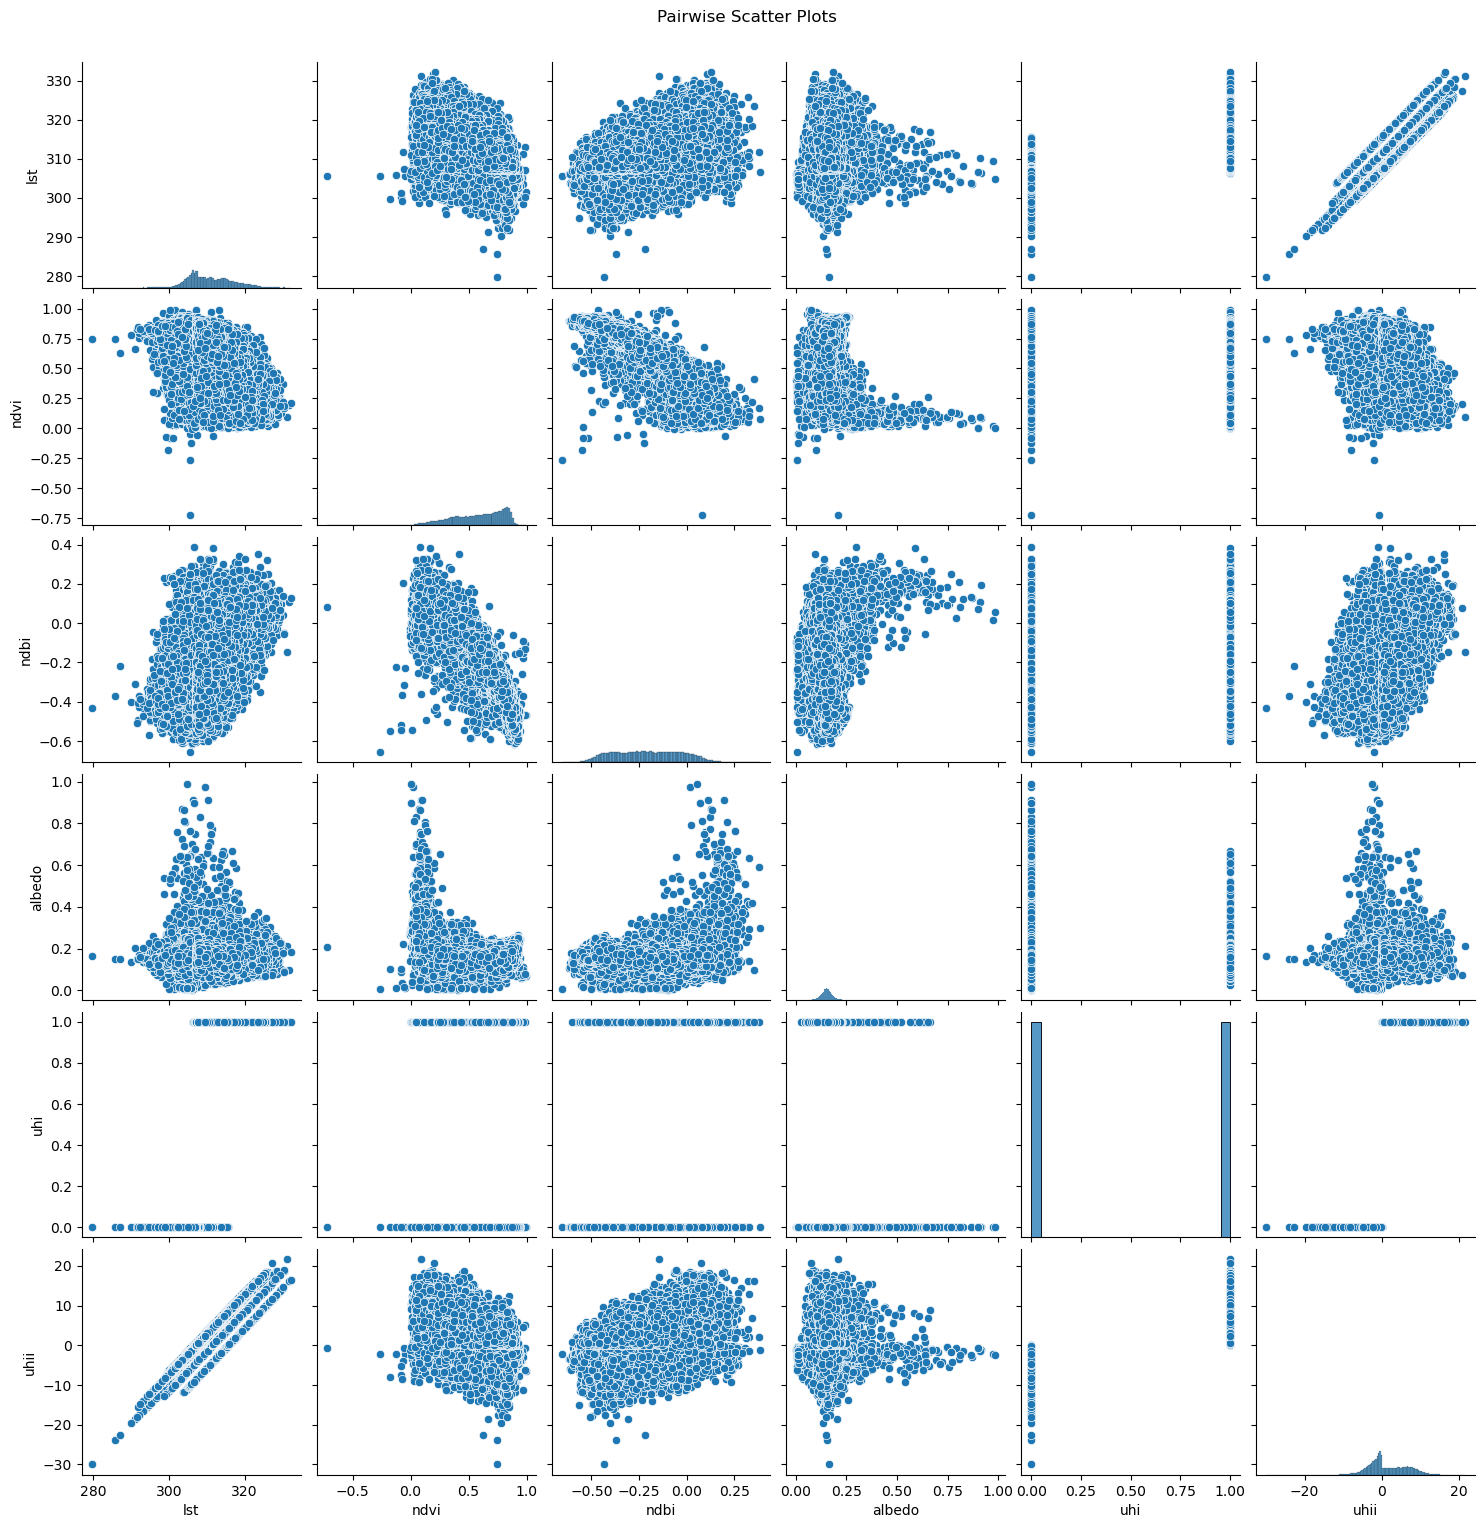

In [15]:
sns.pairplot(samples[['lst', 'ndvi', 'ndbi', 'albedo', 'uhi','uhii']])
plt.suptitle('Pairwise Scatter Plots', y=1.02)
plt.show()

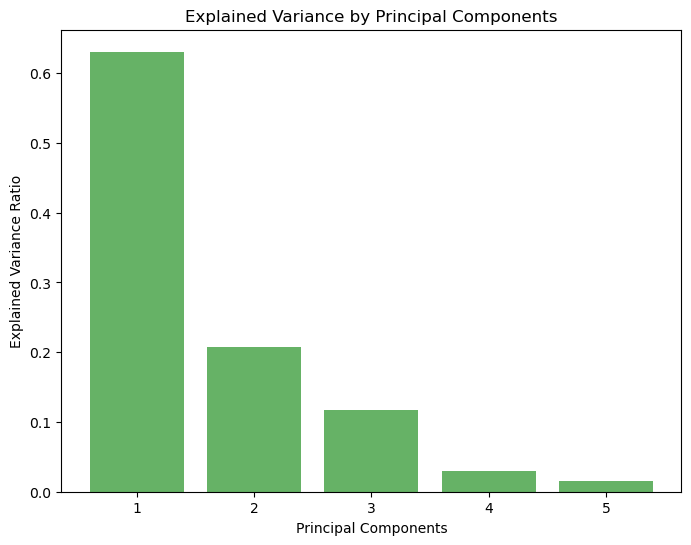

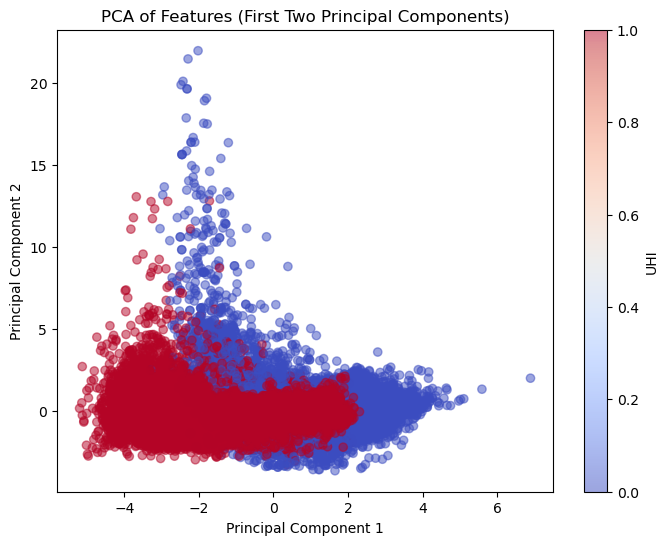

PCA Component Loadings (Contributions of Features to Components):
             PC1       PC2       PC3       PC4       PC5
lst    -0.493009 -0.146930 -0.483919  0.707513  0.024537
ndvi    0.504055 -0.111309 -0.503378  0.007853 -0.692883
ndbi   -0.510550  0.134188  0.450331  0.005093 -0.720076
albedo -0.037394  0.957018 -0.285453 -0.023462  0.026170
uhii   -0.490726 -0.179255 -0.477652 -0.706249  0.010815


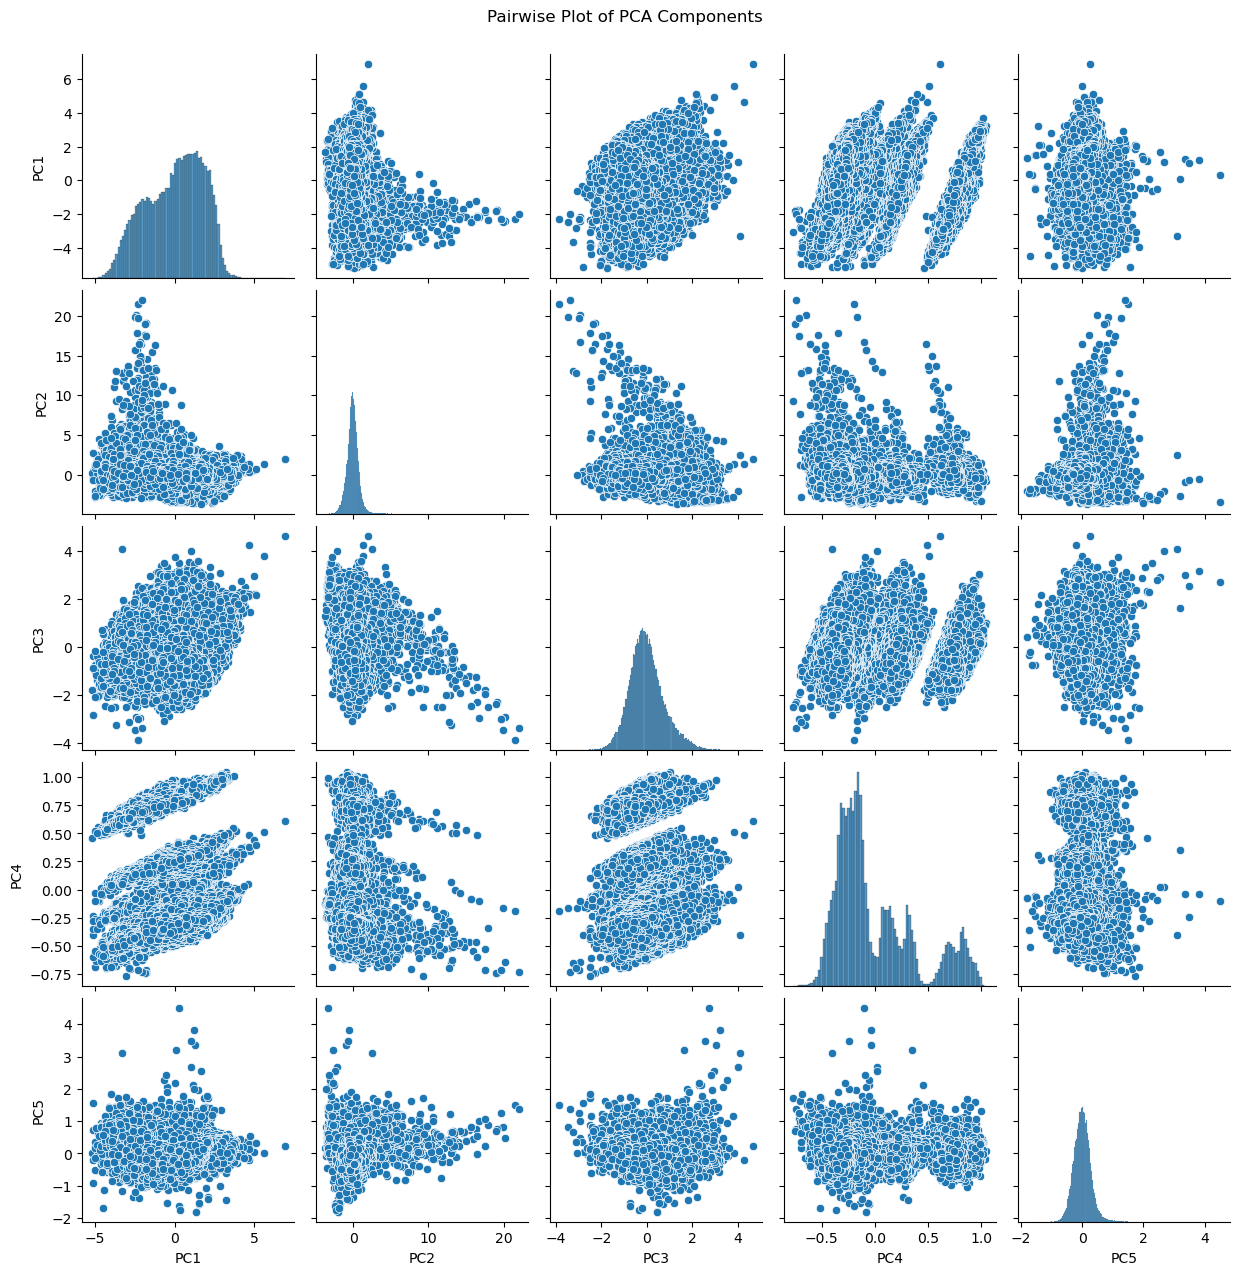

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'samples' is the DataFrame with your data

# 1. Select the features for PCA (excluding 'uhi' if it's a target)
features = ['lst', 'ndvi', 'ndbi', 'albedo','uhii']  # You can adjust this list

# 2. Standardize the features
X = samples[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Run PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 4. Explained variance ratio (to see how much each component explains the variance)
explained_variance = pca.explained_variance_ratio_

# Plot explained variance ratio for each component
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, color='g')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.show()

# 5. Plot the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=samples['uhi'], cmap='coolwarm', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Features (First Two Principal Components)')
plt.colorbar(label='UHI')
plt.show()

# 6. Display the PCA component loadings (contributions of each feature)
loadings = pca.components_.T  # Transpose to match features to components
loading_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(len(features))], index=features)

# Print the loadings DataFrame (it shows how much each feature contributes to each PC)
print("PCA Component Loadings (Contributions of Features to Components):")
print(loading_df)

# 7. You can also plot all the components in a pairplot if you want to visualize correlations
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(len(features))])
sns.pairplot(pca_df)
plt.suptitle('Pairwise Plot of PCA Components', y=1.02)
plt.show()


## Merge training samples with ancillary data (from ODC)

In [11]:
single_positions = samples.drop_duplicates(subset=['x', 'y']).reset_index(drop=True)[['x','y']]
single_x_positions = single_positions.x.values
single_y_positions = single_positions.y.values

odc_df = fetch_from_odc(
    odc_datasets, 
    samples,
    x=xr.DataArray(single_x_positions, dims=['index']),
    y=xr.DataArray(single_y_positions, dims=['index'])
)

# set UHI column as integer
odc_df['uhi'] = odc_df['uhi'].apply(
    lambda x: int(x),
).astype('int8')

#coordinates as float32 to reduce size in disk
odc_df['x'] = odc_df['x'].astype('float64')
odc_df['y'] = odc_df['y'].astype('float64')
odc_df['lst'] = odc_df['lst'].astype('float32')
odc_df['ndvi'] = odc_df['ndvi'].astype('float32')
odc_df['albedo'] = odc_df['albedo'].astype('float32')
odc_df['landcover'] = odc_df['landcover'].astype('int32')
odc_df['uhii'] = odc_df['uhii'].astype('float32')
odc_df['uhi'] = odc_df['uhi'].astype('uint8')

print("ready")
odc_df
    

Sampling building_height
69932 69870
Sampling densita_popolazione
Sampling main_road_distance
Sampling river_distance
Sampling water_distance
odc_df Ready!
ready


,x,y,landcover,uhi,uhii,ndvi,ndbi,albedo,lst,raster,building_height,densita_popolazione,main_road_distance,river_distance,water_distance
0,498936.1148,5039675.992,2,0,-1.437195,0.621937,-0.402585,0.141624,306.281891,2016.0,0.0,0.0,439.089966,109.772491,109.772491
1,508646.1148,5024915.992,1,0,-2.409637,0.746379,-0.370001,0.139510,305.309448,2016.0,0.0,0.0,820.137207,141.155945,26.925823
2,501531.1148,5029345.992,2,0,-4.547577,0.860025,-0.418898,0.180081,303.171509,2016.0,0.0,0.0,5.000000,249.649750,249.649750
3,486811.1148,5038835.992,3,0,-0.268219,0.808178,-0.389560,0.147665,307.450867,2016.0,0.0,0.0,127.475494,0.000000,0.000000
4,526396.1148,5027655.992,2,0,-0.985992,0.865068,-0.491505,0.136227,306.733093,2016.0,0.0,0.0,1034.081787,245.458755,245.458755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69865,523241.1148,5039620.992,6,1,4.269958,0.768588,-0.304883,0.161047,311.465332,2018.0,0.0,0.0,375.000000,236.326050,236.326050
69866,526151.1148,5038775.992,4,1,6.614716,0.773028,-0.263962,0.142503,313.810089,2018.0,0.0,0.0,695.431519,1617.791748,628.351013
69867,523886.1148,5034140.992,5,1,8.043457,0.531571,-0.093952,0.142439,315.238831,2018.0,0.0,0.0,705.070923,11.180340,11.180340
69868,497166.1148,5042860.992,5,1,5.056091,0.803211,-0.315610,0.168468,312.251465,2018.0,0.0,0.0,411.825226,140.000000,10.000000


In [12]:
#Encode Columns
train_df = odc_df.copy()
if encode:
    #encode categorical columns
    encoding_columns = ['landcover']
    encoders = {
        "landcover": OneHotEncoder(sparse=False, dtype='uint16', handle_unknown='ignore')
    }

    for enc in encoding_columns:
        enc_list = train_df[enc].values.reshape(-1, 1)
        encoded_data = encoders[enc].fit_transform(enc_list)

        encoded_columns = [f"{enc}_{category}" for category in encoders[enc].get_feature_names_out([enc])]
        train_df = pd.concat(
            [train_df, pd.DataFrame(encoded_data, columns=encoded_columns, dtype='int32')], 
            axis=1,
            join='inner'
        )
        train_df = train_df.drop(columns=[enc])

    train_df = train_df.dropna()

    #drop resulting _nan columns
    _nan_columns = list(filter(lambda x: '_nan' in x, list(train_df.columns)))
    train_df = train_df.drop(columns=_nan_columns)

    
#drop raster, x, and y columns
train_df_complete = train_df.drop(columns=['raster','x','y'])

for col in odc_datasets:
    train_df_complete = train_df_complete.loc[
        train_df_complete[col] != -9999
    ]

train_df_complete


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,uhi,uhii,ndvi,ndbi,albedo,lst,building_height,densita_popolazione,main_road_distance,river_distance,water_distance,landcover_landcover_1,landcover_landcover_2,landcover_landcover_3,landcover_landcover_4,landcover_landcover_5,landcover_landcover_6
0,0,-1.437195,0.621937,-0.402585,0.141624,306.281891,0.0,0.000,439.089966,109.772491,109.772491,0,1,0,0,0,0
1,0,-2.409637,0.746379,-0.370001,0.139510,305.309448,0.0,0.000,820.137207,141.155945,26.925823,1,0,0,0,0,0
2,0,-4.547577,0.860025,-0.418898,0.180081,303.171509,0.0,0.000,5.000000,249.649750,249.649750,0,1,0,0,0,0
3,0,-0.268219,0.808178,-0.389560,0.147665,307.450867,0.0,0.000,127.475494,0.000000,0.000000,0,0,1,0,0,0
4,0,-0.985992,0.865068,-0.491505,0.136227,306.733093,0.0,0.000,1034.081787,245.458755,245.458755,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69365,1,1.123657,0.851039,-0.424239,0.190891,308.319031,0.0,0.000,317.056763,55.901699,55.901699,0,0,0,0,0,1
69366,1,4.970642,0.750754,-0.284282,0.138834,312.166016,0.0,0.000,5.000000,300.000000,133.416641,0,0,0,1,0,0
69367,1,0.528931,0.744383,-0.298435,0.133182,307.724304,0.0,0.008,301.039856,206.155273,206.155273,0,0,0,0,1,0
69368,1,2.687439,0.645628,-0.228382,0.128178,309.882812,0.0,0.000,739.797302,299.207275,299.207275,0,0,0,0,1,0


In [13]:
train_df_complete = train_df_complete[['uhii', 'ndvi', 'ndbi', 'albedo','building_height',
       'densita_popolazione', 'main_road_distance', 'river_distance',
       'water_distance', 'landcover_landcover_1', 'landcover_landcover_2',
       'landcover_landcover_3', 'landcover_landcover_4',
       'landcover_landcover_5', 'landcover_landcover_6']]

In [14]:
train_df_complete

,uhii,ndvi,ndbi,albedo,building_height,densita_popolazione,main_road_distance,river_distance,water_distance,landcover_landcover_1,landcover_landcover_2,landcover_landcover_3,landcover_landcover_4,landcover_landcover_5,landcover_landcover_6
0,-1.437195,0.621937,-0.402585,0.141624,0.0,0.000,439.089966,109.772491,109.772491,0,1,0,0,0,0
1,-2.409637,0.746379,-0.370001,0.139510,0.0,0.000,820.137207,141.155945,26.925823,1,0,0,0,0,0
2,-4.547577,0.860025,-0.418898,0.180081,0.0,0.000,5.000000,249.649750,249.649750,0,1,0,0,0,0
3,-0.268219,0.808178,-0.389560,0.147665,0.0,0.000,127.475494,0.000000,0.000000,0,0,1,0,0,0
4,-0.985992,0.865068,-0.491505,0.136227,0.0,0.000,1034.081787,245.458755,245.458755,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69365,1.123657,0.851039,-0.424239,0.190891,0.0,0.000,317.056763,55.901699,55.901699,0,0,0,0,0,1
69366,4.970642,0.750754,-0.284282,0.138834,0.0,0.000,5.000000,300.000000,133.416641,0,0,0,1,0,0
69367,0.528931,0.744383,-0.298435,0.133182,0.0,0.008,301.039856,206.155273,206.155273,0,0,0,0,1,0
69368,2.687439,0.645628,-0.228382,0.128178,0.0,0.000,739.797302,299.207275,299.207275,0,0,0,0,1,0


In [15]:
train_df = train_df_complete.copy()

## Training process thru the AI processor module

Train the model with specified parameters.

In [16]:
model_name = 'ANN'
model_type = 'regression'
grid_search_flag = False
target_column = 'uhii'

In [18]:
model = AIProcessor(model_name,model_type,grid_search_flag)
X = train_df.drop(target_column, axis=1)
y = train_df[target_column]
model.fit(X,y)
model.assess()

431/431 [==============================] - 0s 268us/step
Regression Metrics:
Mean Absolute Error (MAE): 2.6758611
Mean Squared Error (MSE): 12.0379925
Root Mean Squared Error (RMSE): 3.4695811
R² Score: 0.5053618898910532


Plot the predicted vs. actual values

431/431 [==============================] - 0s 271us/step


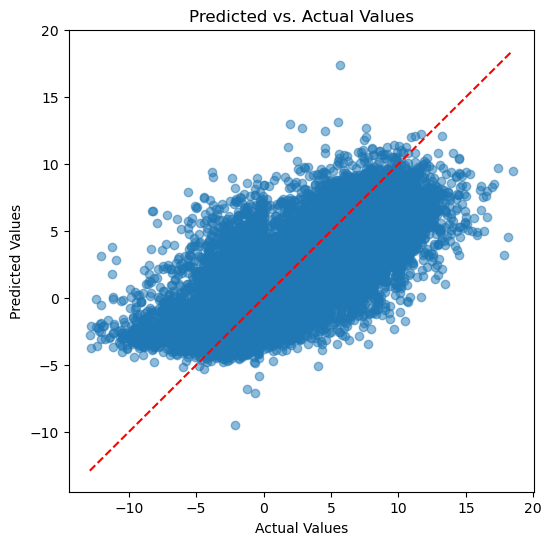

In [19]:
plt.figure(figsize=(6,6))
plt.scatter(model.y_test, model.model.predict(model.X_test), alpha=0.5)
plt.plot([min(model.y_test), max(model.y_test)], [min(model.y_test), max(model.y_test)], 'r', linestyle="dashed")  # Ideal 1:1 line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual Values")
plt.show()

## Get Random Forest Importances

Train a random forest model the get the overall feature importance

In [20]:
rf_model = AIProcessor('RF','regression',False)
X = train_df.drop('uhii', axis=1)
y = train_df['uhii']
rf_model.fit(X,y)
rf_model.assess()

Regression Metrics:
Mean Absolute Error (MAE): 2.611801512497696
Mean Squared Error (MSE): 11.835937834744412
Root Mean Squared Error (RMSE): 3.440339784780627
R² Score: 0.5136642315218921


In [21]:
if rf_model.model_type == 'RF':
    importances = pd.DataFrame(rf_model.model.feature_importances_)
    importances['label'] = pd.Series(X.columns)
    importances = importances.sort_values(by=0, ascending=False).reset_index(drop=True)
    importer.show_plot(importances, 'label', 0)

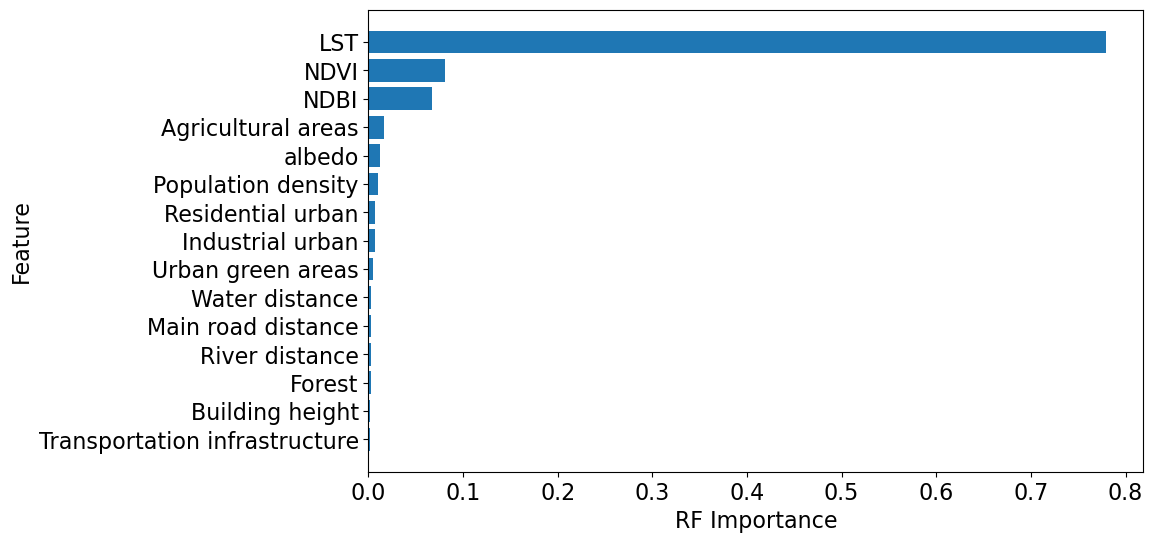

In [71]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})
# Plot
plt.figure(figsize=(10, 6))
plt.barh(list(reversed(importances['label'])),list(reversed(importances[0])))
plt.xlabel('RF Importance', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.show()


# PREDICTION

Predict in the whole area of interest (metropolitan area of Milan) using the previously trained model. Otherwise, read the model and scaler using the AI Processor load_model and load_scaler functions.

In [22]:
# predict the whole image
importer = processing.HarmoniaProcessor()

# get raster parameters from landcover
with rasterio.open(landcover_path, driver="GTiff") as base_raster:
    transform = base_raster.transform
    init_x = transform[2]
    init_y = transform[5]
    step_x = transform[0]
    step_y = transform[4]

#import samples
base_path = f'training_samples'
#sufix = '_DUSAF'
predict_path = f'{base_path}/{city}_predict_summer_mosaic.csv'
predict = importer.import_df(predict_path, date_format=None)

predict['lst'] = predict['lst'].astype('float32')
predict['ndvi'] = predict['ndvi'].astype('float32')
predict['ndbi'] = predict['ndbi'].astype('float32')
predict['albedo'] = predict['albedo'].astype('float32')
predict['landcover'] = predict['landcover'].astype('int32')
predict['x'] = predict['x'].astype('float64')
predict['y'] = predict['y'].astype('float64')

predict['landcover'] = predict['landcover']#.apply(map_urban_atlas_class).astype('int32')

predict['x'] = predict['x'].apply(
    lambda x: init_x + (x * step_x)
)
predict['y'] = predict['y'].apply(
    lambda y: init_y + (y * step_y)
)

predict_x_positions = predict.x.values
predict_y_positions = predict.y.values

full_data_df = fetch_from_odc(
    odc_datasets, 
    predict,
    x=xr.DataArray(predict_x_positions, dims=['index']),
    y=xr.DataArray(predict_y_positions, dims=['index'])
)

#remove water pixels
full_data_df = full_data_df.loc[
    full_data_df['landcover'] != WATER
].reset_index(drop=True)
print("ready")

#remove nodata from odc datasets
for col in odc_datasets:
    full_data_df = full_data_df.loc[
        full_data_df[col] != 9999
    ].reset_index(drop=True)

full_data_df

Sampling building_height
63008502 63008502
Sampling densita_popolazione
Sampling main_road_distance
Sampling river_distance
Sampling water_distance
odc_df Ready!
ready


,x,y,landcover,lst,ndvi,ndbi,albedo,building_height,densita_popolazione,main_road_distance,river_distance,water_distance
0,495341.1148,5054280.992,6,309.411682,0.451056,-0.141100,0.138983,0.0,0.0,3550.003662,916.856079,916.856079
1,495346.1148,5054280.992,6,309.789551,0.684750,-0.268170,0.124033,0.0,0.0,3551.936035,920.570435,920.570435
2,495351.1148,5054280.992,6,309.789551,0.684750,-0.268170,0.124033,0.0,0.0,3553.874512,924.296997,924.296997
3,495321.1148,5054275.992,6,309.411682,0.451056,-0.141100,0.138983,0.0,0.0,3537.711182,898.721313,898.721313
4,495326.1148,5054275.992,6,309.411682,0.451056,-0.141100,0.138983,0.0,0.0,3539.622070,902.399597,902.399597
...,...,...,...,...,...,...,...,...,...,...,...,...
61883753,537921.1148,5001000.992,5,310.331116,0.545597,-0.131444,0.162420,0.0,0.0,0.000000,2256.014160,2256.014160
61883754,537926.1148,5001000.992,5,310.331116,0.545597,-0.131444,0.162420,0.0,0.0,0.000000,2252.026855,2252.026855
61883755,537931.1148,5001000.992,5,310.331116,0.545597,-0.131444,0.162420,0.0,0.0,0.000000,2248.043457,2248.043457
61883756,537936.1148,5001000.992,5,309.823730,0.585484,-0.176977,0.159565,0.0,0.0,0.000000,2244.064453,2244.064453


In [23]:
full_data_df.describe()

,x,y,landcover,lst,ndvi,ndbi,albedo,building_height,densita_popolazione,main_road_distance,river_distance,water_distance
count,6.188376e+07,6.188376e+07,6.188376e+07,6.188376e+07,6.188376e+07,6.188376e+07,6.188376e+07,6.188376e+07,6.188376e+07,6.188376e+07,6.188376e+07,6.188376e+07
mean,5.095738e+05,5.034256e+06,3.786028e+00,3.133081e+02,5.614253e-01,-1.839705e-01,1.554071e-01,8.198496e-01,1.942512e-03,7.171603e+02,2.273089e+02,2.054238e+02
std,1.585842e+04,9.475204e+03,1.744005e+00,4.998028e+00,2.486722e-01,1.687339e-01,2.860503e-02,3.348141e+00,5.186195e-03,7.540798e+02,3.879529e+02,3.223324e+02
min,4.770711e+05,5.001001e+06,1.000000e+00,2.972355e+02,-1.215615e+02,-2.064669e+01,-1.553858e-03,-1.000000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.966761e+05,5.027106e+06,2.000000e+00,3.091920e+02,4.063341e-01,-3.312851e-01,1.398771e-01,0.000000e+00,0.000000e+00,2.093442e+02,3.807887e+01,3.807887e+01
50%,5.084811e+05,5.035346e+06,5.000000e+00,3.141304e+02,5.886993e-01,-1.700488e-01,1.553846e-01,0.000000e+00,0.000000e+00,4.913502e+02,9.604687e+01,9.433981e+01
75%,5.220411e+05,5.041846e+06,5.000000e+00,3.173698e+02,7.419802e-01,-4.531938e-02,1.701659e-01,0.000000e+00,1.000000e-03,9.350535e+02,2.263846e+02,2.192031e+02
max,5.430561e+05,5.054281e+06,8.000000e+00,3.345867e+02,6.146404e+01,5.212952e+00,1.211763e+00,2.007380e+02,1.580000e-01,5.238096e+03,3.820906e+03,3.648150e+03


In [24]:
if encode:
    #encode categorical columns
    encoding_columns = ['landcover']
    all_encoded_columns = []
    for enc in encoding_columns:
        enc_list = full_data_df[enc].values.reshape(-1, 1)
        encoded_data = encoders[enc].transform(enc_list)

        encoded_columns = [f"{enc}_{category}" for category in encoders[enc].get_feature_names_out([enc])]
        print(encoded_columns)
        full_data_df = pd.concat([full_data_df, pd.DataFrame(encoded_data, columns=encoded_columns)], axis=1)
        all_encoded_columns += encoded_columns.copy()
        full_data_df = full_data_df.drop(columns=[enc])

    full_data_df = full_data_df.dropna()
    for enc_col in all_encoded_columns:
        full_data_df[enc_col] = full_data_df[enc_col].astype('uint16')

    #drop resulting _nan columns
    _nan_columns = list(filter(lambda x: '_nan' in x, list(full_data_df.columns)))
    full_data_df = full_data_df.drop(columns=_nan_columns)

full_data_df

['landcover_landcover_1', 'landcover_landcover_2', 'landcover_landcover_3', 'landcover_landcover_4', 'landcover_landcover_5', 'landcover_landcover_6']


,x,y,lst,ndvi,ndbi,albedo,building_height,densita_popolazione,main_road_distance,river_distance,water_distance,landcover_landcover_1,landcover_landcover_2,landcover_landcover_3,landcover_landcover_4,landcover_landcover_5,landcover_landcover_6
0,495341.1148,5054280.992,309.411682,0.451056,-0.141100,0.138983,0.0,0.0,3550.003662,916.856079,916.856079,0,0,0,0,0,1
1,495346.1148,5054280.992,309.789551,0.684750,-0.268170,0.124033,0.0,0.0,3551.936035,920.570435,920.570435,0,0,0,0,0,1
2,495351.1148,5054280.992,309.789551,0.684750,-0.268170,0.124033,0.0,0.0,3553.874512,924.296997,924.296997,0,0,0,0,0,1
3,495321.1148,5054275.992,309.411682,0.451056,-0.141100,0.138983,0.0,0.0,3537.711182,898.721313,898.721313,0,0,0,0,0,1
4,495326.1148,5054275.992,309.411682,0.451056,-0.141100,0.138983,0.0,0.0,3539.622070,902.399597,902.399597,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61883753,537921.1148,5001000.992,310.331116,0.545597,-0.131444,0.162420,0.0,0.0,0.000000,2256.014160,2256.014160,0,0,0,0,1,0
61883754,537926.1148,5001000.992,310.331116,0.545597,-0.131444,0.162420,0.0,0.0,0.000000,2252.026855,2252.026855,0,0,0,0,1,0
61883755,537931.1148,5001000.992,310.331116,0.545597,-0.131444,0.162420,0.0,0.0,0.000000,2248.043457,2248.043457,0,0,0,0,1,0
61883756,537936.1148,5001000.992,309.823730,0.585484,-0.176977,0.159565,0.0,0.0,0.000000,2244.064453,2244.064453,0,0,0,0,1,0


In [25]:
#Convert all odc dataset columns to float32 to save disk
for col in odc_datasets:
    full_data_df[col] = full_data_df[col].astype('float32')

full_data_df

,x,y,lst,ndvi,ndbi,albedo,building_height,densita_popolazione,main_road_distance,river_distance,water_distance,landcover_landcover_1,landcover_landcover_2,landcover_landcover_3,landcover_landcover_4,landcover_landcover_5,landcover_landcover_6
0,495341.1148,5054280.992,309.411682,0.451056,-0.141100,0.138983,0.0,0.0,3550.003662,916.856079,916.856079,0,0,0,0,0,1
1,495346.1148,5054280.992,309.789551,0.684750,-0.268170,0.124033,0.0,0.0,3551.936035,920.570435,920.570435,0,0,0,0,0,1
2,495351.1148,5054280.992,309.789551,0.684750,-0.268170,0.124033,0.0,0.0,3553.874512,924.296997,924.296997,0,0,0,0,0,1
3,495321.1148,5054275.992,309.411682,0.451056,-0.141100,0.138983,0.0,0.0,3537.711182,898.721313,898.721313,0,0,0,0,0,1
4,495326.1148,5054275.992,309.411682,0.451056,-0.141100,0.138983,0.0,0.0,3539.622070,902.399597,902.399597,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61883753,537921.1148,5001000.992,310.331116,0.545597,-0.131444,0.162420,0.0,0.0,0.000000,2256.014160,2256.014160,0,0,0,0,1,0
61883754,537926.1148,5001000.992,310.331116,0.545597,-0.131444,0.162420,0.0,0.0,0.000000,2252.026855,2252.026855,0,0,0,0,1,0
61883755,537931.1148,5001000.992,310.331116,0.545597,-0.131444,0.162420,0.0,0.0,0.000000,2248.043457,2248.043457,0,0,0,0,1,0
61883756,537936.1148,5001000.992,309.823730,0.585484,-0.176977,0.159565,0.0,0.0,0.000000,2244.064453,2244.064453,0,0,0,0,1,0


In [26]:
columns = ['ndvi', 'ndbi','albedo', 'building_height', 'densita_popolazione',
       'main_road_distance', 'river_distance', 'water_distance',
       'landcover_landcover_1', 'landcover_landcover_2',
       'landcover_landcover_3', 'landcover_landcover_4',
       'landcover_landcover_5', 'landcover_landcover_6']

In [27]:
predict_df = full_data_df.copy()

data_coord = pd.concat([predict_df[col] for col in ['y', 'x']], axis=1)
predict_df = predict_df.drop(columns=['x','y'])

#Fix order column for model
column_order = ["ndvi",'ndbi',"albedo"]
column_order += odc_datasets
column_order += ["landcover_landcover_1","landcover_landcover_2","landcover_landcover_3","landcover_landcover_4","landcover_landcover_5","landcover_landcover_6"]

predict_df = predict_df[column_order]

# ignore the warnings for feature names. The important thing is that the dataset has the same order of the training one
# to remove the warnings create a dataframe with the normalized dataset and the column list
batch_size = 1000000
full_data_predict = model.scaler.transform(predict_df)


# predict probabilities in batches
probs = []
for i in range(0, len(full_data_predict), batch_size):
    batch = full_data_predict[i:i+batch_size]
    batch_probs = model.predict(batch)#[:,1]
    probs.append(batch_probs)
    print(f'Done {i}')

full_data_prob = np.concatenate(probs, axis=0)
full_data_prob


31250/31250 [==============================] - 8s 265us/step
Done 0
31250/31250 [==============================] - 8s 265us/step
Done 1000000
31250/31250 [==============================] - 9s 272us/step
Done 2000000
31250/31250 [==============================] - 8s 264us/step
Done 3000000
31250/31250 [==============================] - 8s 264us/step
Done 4000000
31250/31250 [==============================] - 8s 270us/step
Done 5000000
31250/31250 [==============================] - 8s 265us/step
Done 6000000
31250/31250 [==============================] - 8s 264us/step
Done 7000000
31250/31250 [==============================] - 8s 262us/step
Done 8000000
31250/31250 [==============================] - 8s 268us/step
Done 9000000
31250/31250 [==============================] - 8s 266us/step
Done 10000000
31250/31250 [==============================] - 9s 272us/step
Done 11000000
31250/31250 [==============================] - 8s 269us/step
Done 12000000
31250/31250 [============================

array([[ 3.4245355e+00],
       [-2.5502220e-03],
       [ 3.6204383e-03],
       ...,
       [ 4.3019996e+00],
       [ 3.4097257e+00],
       [ 3.4077535e+00]], dtype=float32)

In [29]:
#append the x,y coordinates to the probabilities
full_data_df = pd.DataFrame(full_data_prob).reset_index(drop=True)
full_data_df['x'] = data_coord['x'].reset_index(drop=True)
full_data_df['y'] = data_coord['y'].reset_index(drop=True)

In [30]:
full_data_df.rename(columns={0:'probability'}, inplace=True)
full_data_df = full_data_df.round({'probability': 4})
full_data_df['probability'] = full_data_df['probability'].astype('float32')


In [31]:
base_path = 'predictions'
model_name = 'ANN_regression_test'
predictions_path = f'{base_path}/{city}_UHII_{model_name}_predictions_{sufix}.csv'
print(f'Saving to {predictions_path}')
full_data_df.to_csv(predictions_path)


Saving to predictions/MILANO_UHII_ANN_regression_test_predictions__summer_mosaic_10000.csv


In [39]:
pickle.dump(model.model, open(f'model/model_{model_name}_UHI_regression_summer_avg_10000.pkl', 'wb'))

In [40]:
pickle.dump(model.scaler, open(f'scaler_{model_name}_UHI_regression_summer_avg_10000.pkl','wb'))